In [1]:
from IPython.display import Image, display
from ipywidgets import Dropdown, Output
from IPython.display import display

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Conditional pocket diffusion with PILOT<sup>[1](https://pubs.rsc.org/en/content/articlelanding/2024/sc/d4sc03523b), [2](https://github.com/pfizer-opensource/e3moldiffusion)</sup>

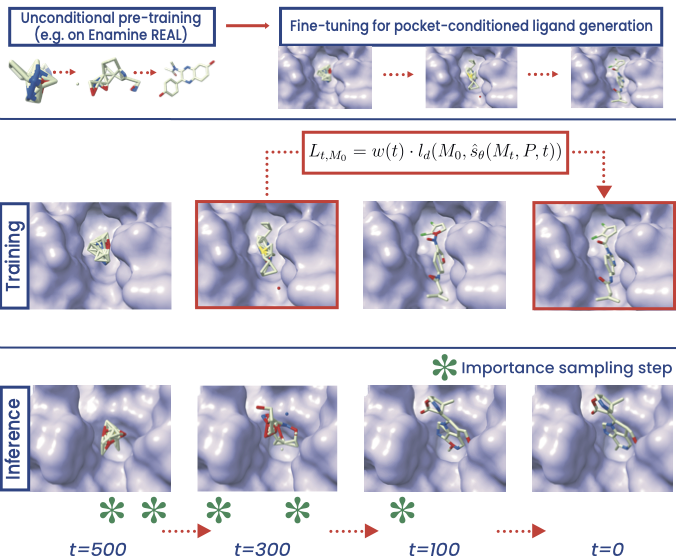

In [2]:
Image(filename="images/pilot.png")

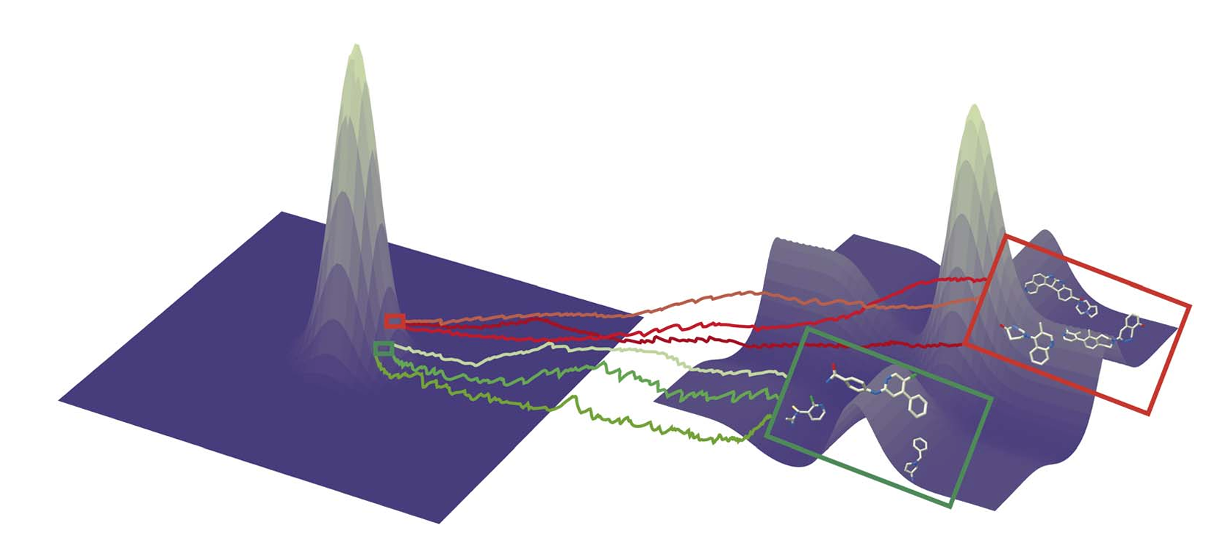

In [3]:
Image(filename="images/pilot_sampling.png")

## Pocket conditioned 3D diffusion model

**Loss function:**<br></br>
$L_t = \frac{1}{2}(w(t) × l_d(M_0, p_θ(M_t, t, P)))$

**Forward diffusion process:**<br></br>
$q(X_t|X_0) = N(X_t|\sqrt{\bar{\alpha}}_t X_0, (1 - \bar{\alpha}_t)I)$

**Categorical diffusion process:**<br></br>
$q(C_t|C_0) = C(C_t|\bar{\alpha}_t C_0 + (1 - \bar{\alpha}_t)\tilde{C})$

**Variance-preserving adaptive noise scheduler:**<br></br>
$\bar{\alpha}_t = \prod_{k=1}^t (1 - β_k) ∈ (0,1)$

## EQGAT-diff

+ Initial one-hot encoded edge features categorize the presence of none, single, double, triple, and aromatic bonds: $E \in \mathbb{R}^{(n×n×5)} $

+ Distance matrix: $D \in \mathbb{R}^{(n×n)}$

+ Outer product between the one-hot encoding of the bond feature with an exponential radial basis function with 20 channels<br></br>
$$
e^*_{ij} = e_{ij} \otimes g_{rbf}(d_{ij}) \in \mathbb{R}^{(5×20)}
$$
$e^*_{ij}$ vectorized into $\mathbb{R}^{100}$<br></br>
$e^{(0)}_{ij} \in \mathbb{R}^{128}$

+ After 12 rounds of message-passing, we use separate prediction heads for predicting coordinates, atoms, charges, and bond types

## Training

$$
L_p,t = w(t)||c_\theta - \pi_\theta,\delta(M_t, t, P)||^2
$$

+ Diffusion loss $L_t$ is optimized for each sample, which under the data prediction parameterization means a MSE loss for atomic coordinates and CE loss for discretevalued modalities including atom and bond types of the ligand molecule
+ $M_t$ is a noisy ligand

## Classifier guidance

+ Not in use in my implementation

$$
\tilde{X}_{t-1} ~ p_\theta(X_{t-1}|M_t, P)
$$
$$
X_{t-1} = \tilde{X}_{t-1} + \lambda_1\nabla_{X_t}f_{\delta_1}(M_t, P) - \lambda_2\nabla_{X_t}f_{\delta_2}(M_t, P)
$$

## Multi-objective importance sampling for property-guided ligand generation

### Inputs:
- Pocket $P$
- condition $c$
- number of ligands $K$
- $\tau$ temperature
- every importance step $N$
- diffusion model $p_\theta$
- property models $p_\delta$

### Output:
- Set of generated ligands $\{M_i\}^K_{i=1}$ conditioned on $(P,c)$

### Algorithm:

$M_T \sim N(0,I) × C(\hat{p}_c)$ ⊳ (Sample K ligands from prior distribution)

**for** $t = T-1, ..., 1$ **do** ⊳ (Reverse diffusion trajectory)<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;Sample $M_{t-1} \sim p_θ(M_{t-1}|M_t, P)$<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;**if** $t$ mod $N = 0$ **then** ⊳ (Importance step, every $N$ steps)<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**for** $k = 1, ..., K$ **do**<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**if** optimizing for specific c<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\tilde{w}_k = p_\delta(c|M_{k,t-1}, P)$ ⊳ (Compute probability value)<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**else**<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\tilde{w}_k = f_\delta(M_{k,t-1}, P)$ ⊳ (Compute raw probability value, here maximization)<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**end if**<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**end for**<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Importance weight computation using softmax with temperature $\tau$: ${\{M_{k,t-1}, \tilde{w}_k\}}^K_{k=1} : w_k = \frac{exp(\tilde{w}̃_k/\tau)}{\sum^K_{j=1} exp(\tilde{w}_j/\tau)}$<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Draw new population with replacement: ${\{M_{k,t-1}\}}^K_{k=1} \sim Multinomial({M_{k,t-1}}^K_{k=1}, {w_k}^K_{k=1})$<br></br>
&nbsp;&nbsp;&nbsp;&nbsp;**end if**<br></br>
**end for**<br></br>
return ${M_{k,0}}^K_{k=1}$ ⊳ (Final ligands)

**Where:**
- $N(0,I)$ = standard normal distribution
- $C(p_c)$ = constraint based on pocket $p_c$
- $\tau$ = temperature parameter for softmax
- $\tilde{w}_k$ = raw importance weight
- $w_k$ = normalized importance weight

# Preliminary results

In [4]:
df = pd.read_csv("./images/evaluation.csv", skiprows=lambda x: (x != 0) and not x % 2)
df = df.iloc[:, 1:]

In [5]:
plot_output = Output()

def update_plot(change):
    if change['name'] == 'value':
        plot_output.clear_output(wait=True)
        
        with plot_output:
            selected_column = change['new']
            
            plt.figure(figsize=(8, 5))
            plt.scatter(df["epoch"], df[selected_column])
            plt.title(f'Plot of {selected_column}')
            plt.xlabel("Epoch")
            plt.ylabel(selected_column)
            plt.grid(True)
            plt.show()

dropdown = Dropdown(
    options=df.columns,
    value=df.columns[0],
    description="Metric:",
    disabled=False,
)

dropdown.observe(update_plot, names='value')

display(dropdown, plot_output)

with plot_output:
    plt.figure(figsize=(8, 5))
    plt.scatter(df["epoch"], df[dropdown.value])
    plt.title(f'Plot of {dropdown.value}')
    plt.xlabel("Epoch")
    plt.ylabel(dropdown.value)
    plt.grid(True)
    plt.show()

Dropdown(description='Metric:', options=('validity', 'sanitize_validity', 'novelty', 'uniqueness', 'sampling/N…

Output()